In [21]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "../trash_classification/dataset/train"
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)


train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(112, 112),
    class_mode='categorical',
    batch_size=64,
    subset='training'
)

validation_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(112, 112),
    class_mode='categorical',
    batch_size=64,
    subset='validation'
)

Found 2759 images belonging to 4 classes.
Found 688 images belonging to 4 classes.


In [3]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(112, 112, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
# model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=(204, 136, 3)),
#     tf.keras.layers.Dense(units=1),
#     tf.keras.layers.Dense(4, activation='softmax')
# ])

In [4]:
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [7]:
%%time

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
]

history = model.fit_generator(
    train_generator,
    epochs=40,
    steps_per_epoch=train_generator.samples // 64,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // 64,
    callbacks=callbacks,
)


Epoch 1/40
43/43 [==============================] - 89s 2s/step - loss: 0.7724 - accuracy: 0.7232 - val_loss: 0.8260 - val_accuracy: 0.7375
Epoch 2/40
43/43 [==============================] - 87s 2s/step - loss: 0.7743 - accuracy: 0.7224 - val_loss: 0.7633 - val_accuracy: 0.7141
Epoch 3/40
43/43 [==============================] - 84s 2s/step - loss: 0.7421 - accuracy: 0.7317 - val_loss: 0.7571 - val_accuracy: 0.7453
Epoch 4/40
43/43 [==============================] - 84s 2s/step - loss: 0.7075 - accuracy: 0.7362 - val_loss: 0.7767 - val_accuracy: 0.7406
Epoch 5/40
43/43 [==============================] - 90s 2s/step - loss: 0.6435 - accuracy: 0.7529 - val_loss: 0.7219 - val_accuracy: 0.7781
Epoch 6/40
43/43 [==============================] - 94s 2s/step - loss: 0.6516 - accuracy: 0.7547 - val_loss: 0.7164 - val_accuracy: 0.7563
Epoch 7/40
43/43 [==============================] - 92s 2s/step - loss: 0.6585 - accuracy: 0.7562 - val_loss: 0.6074 - val_accuracy: 0.7625
Epoch 8/40
43/43 [==

In [8]:
model.save("cycle_classifier_proto.h5")

Text(0.5, 1.0, 'Training and validation loss')

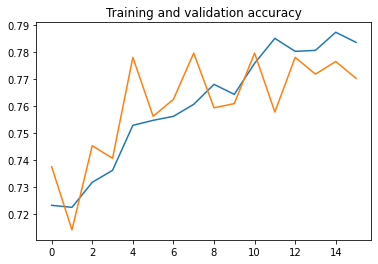

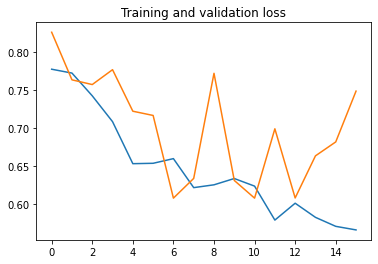

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict_generator(validation_generator, validation_generator.samples // 64+1)
y_pred = np.argmax(Y_pred, axis=1)

In [15]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[  0   2  31   0]
 [  0   4  39   1]
 [  0  18 459  18]
 [  0   3 110   3]]


In [14]:
print('Classification Report')
target_names = ['Autre', 'Organique', 'Recyclable', 'Verre']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Autre       0.00      0.00      0.00        33
   Organique       0.15      0.09      0.11        44
  Recyclable       0.72      0.93      0.81       495
       Verre       0.14      0.03      0.04       116

    accuracy                           0.68       688
   macro avg       0.25      0.26      0.24       688
weighted avg       0.55      0.68      0.60       688



Pistes d'améliorations rapides:
- contrer le déséquilibre des classes (https://medium.com/analytics-vidhya/how-to-apply-data-augmentation-to-deal-with-unbalanced-datasets-in-20-lines-of-code-ada8521320c9)
- utiliser du transfer learning pour commencer avec un modèle plus robuste et déjà entrainé (DenseNet, ResNet, VGG16, EfficientNet)
- équilibrer le dataset en rajoutant/retirant des images

In [33]:
model_DN121 = tf.keras.Sequential([tf.keras.applications.DenseNet121(weights='imagenet',
                                                                   input_shape=(112, 112, 3),
                                                                   include_top=False,
                                                                   pooling='max'
                                                                  ),
                                 tf.keras.layers.Dense(4, activation='softmax')])

In [34]:
model_DN121.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lr_schedule = tf.keras.callbacks.LearningRateScheduler(build_lrfn(), verbose=1)

In [36]:
%%time
history = model_DN121.fit_generator(
    train_generator,
    epochs=15,
    steps_per_epoch=train_generator.samples // 64,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // 64,
    callbacks=[lr_schedule],
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/15
43/43 [==============================] - 90s 2s/step - loss: 1.8094 - accuracy: 0.4074 - val_loss: 2.0469 - val_accuracy: 0.3922

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/15
43/43 [==============================] - 90s 2s/step - loss: 1.1125 - accuracy: 0.6203 - val_loss: 1.3396 - val_accuracy: 0.5453

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/15
43/43 [==============================] - 91s 2s/step - loss: 0.6926 - accuracy: 0.7654 - val_loss: 1.1004 - val_accuracy: 0.6578

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/15
43/43 [==============================] - 90s 2s/step - loss: 0.5478 - accuracy: 0.8126 - val_loss: 1.0296 - val_accuracy: 0.6687

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000004e-05.
Epoch 5/15
43/43 [=========

In [38]:
model_DN121.save("cycle_classifier_DN121.h5")

Text(0.5, 1.0, 'Training and validation loss')

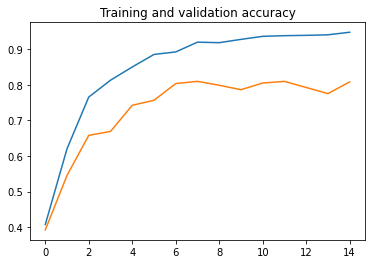

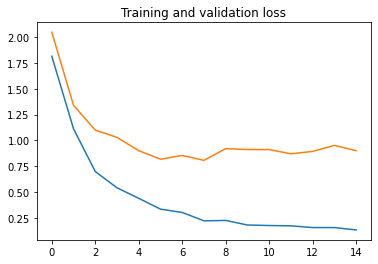

In [39]:
%matplotlib inline

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model_DN121.predict_generator(validation_generator, validation_generator.samples // 64+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = ['Autre', 'Organique', 'Recyclable', 'Verre']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[  0   4  26   3]
 [  1   8  33   2]
 [  6  31 424  34]
 [  4  10  94   8]]
Classification Report
              precision    recall  f1-score   support

       Autre       0.00      0.00      0.00        33
   Organique       0.15      0.18      0.16        44
  Recyclable       0.73      0.86      0.79       495
       Verre       0.17      0.07      0.10       116

    accuracy                           0.64       688
   macro avg       0.26      0.28      0.26       688
weighted avg       0.57      0.64      0.60       688

